In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.cluster import KMeans

In [27]:
df1 = pd.read_csv('trips_2018_cleaned.csv',index_col=0)

In [32]:
df1.head()

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
tripduration,,,,,,,,,,,,,,,,,,
970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1
723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1
496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1
306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1
306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1


# Task 1

In [36]:
all_stations = pd.concat([
    df1[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    df1[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_id': 'start_station_id',
                 'end_station_latitude': 'start_station_latitude',
                 'end_station_longitude': 'start_station_longitude'}
    )
]).drop_duplicates().dropna()

print(f"Total unique stations: {len(all_stations)}")

Total unique stations: 845


Coordinate range:
  Lat: 4511766 to 4530398 meters
  Lon: -6297109 to -6282158 meters

Testing different K values...
K=20: Inertia=6.92e+08
K=23: Inertia=5.97e+08
K=26: Inertia=5.13e+08
K=29: Inertia=4.51e+08
K=32: Inertia=4.06e+08
K=35: Inertia=3.66e+08
K=38: Inertia=3.34e+08
K=41: Inertia=3.02e+08
K=44: Inertia=2.80e+08
K=47: Inertia=2.62e+08
K=50: Inertia=2.47e+08


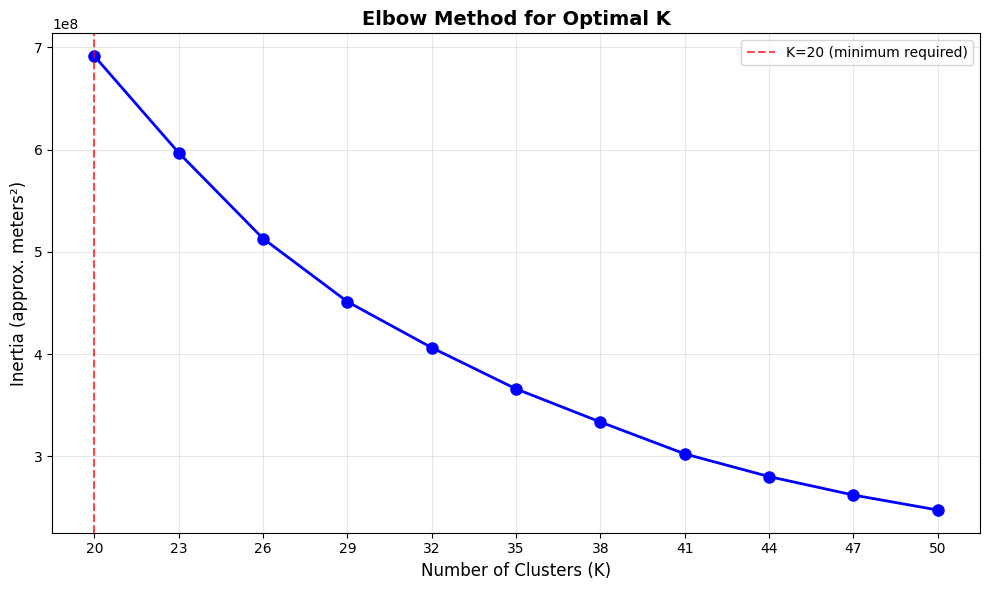

In [48]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ============================================================================
# CONVERT LAT/LON TO APPROXIMATE METERS (SIMPLE METHOD)
# ============================================================================

lat = all_stations['start_station_latitude'].values
lon = all_stations['start_station_longitude'].values

# Approximate conversion for New York area (40.7°N)
# 1 degree latitude ≈ 111,000 meters
# 1 degree longitude ≈ 85,000 meters (at 40°N latitude)

lat_meters = lat * 111000  # meters
lon_meters = lon * 85000   # meters (adjusted for NYC latitude)

X_meters = np.column_stack([lat_meters, lon_meters])

print(f"Coordinate range:")
print(f"  Lat: {lat_meters.min():.0f} to {lat_meters.max():.0f} meters")
print(f"  Lon: {lon_meters.min():.0f} to {lon_meters.max():.0f} meters")

# ============================================================================
# ELBOW METHOD TO FIND OPTIMAL K
# ============================================================================

X = X_meters

k_values = range(20, 51, 3)
inertias = []

print("\nTesting different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=67, n_init=20)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.2e}")

# ============================================================================
# PLOT ELBOW CURVE
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (approx. meters²)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='K=20 (minimum required)')
plt.legend()

plt.tight_layout()
plt.savefig('elbow_plot_meters.png', dpi=300, bbox_inches='tight')
plt.show()


In [60]:
kmeans = KMeans(n_clusters=26, random_state=67, n_init=20)
all_stations['cluster'] = kmeans.fit_predict(X_meters)

In [61]:
station_to_cluster = dict(zip(
    all_stations['start_station_id'], 
    all_stations['cluster']
))

# Add to df1
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)

# Verify
print(f"\nMissing start clusters: {df1['start_cluster'].isna().sum()}")
print(f"Missing end clusters: {df1['end_cluster'].isna().sum()}")

df1.head()


Missing start clusters: 0
Missing end clusters: 0


,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,end_cluster
tripduration,,,,,,,,,,,,,,,,,,,,
970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1,10,7
723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1,10,14
496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1,10,14
306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1,10,10
306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1,10,5


# Task 2

### Hourly demand function

In [62]:
def create_hourly_demand(df, cluster_col, demand_type='pickups'):
    """
    Aggregate demand by cluster, date, and hour
    
    Parameters:
    - cluster_col: 'start_cluster' for pickups or 'end_cluster' for dropoffs
    - demand_type: 'pickups' or 'dropoffs' (for labeling)
    """
    hourly_demand = df.groupby([cluster_col, 'date', 'hour']).size().reset_index(name=demand_type)
    return hourly_demand

# Creating pickup and dropoff datasets
pickups_hourly = create_hourly_demand(df1, 'start_cluster', 'pickups')
dropoffs_hourly = create_hourly_demand(df1, 'end_cluster', 'dropoffs')


### Choosing top clusters for analysis 

In [63]:
# Selecting top 3 clusters by total demand for analysis
cluster_demand = df1.groupby('start_cluster').size().sort_values(ascending=False)
selected_clusters = cluster_demand.head(3).index.tolist()

print(f"SELECTED CLUSTERS FOR PREDICTION: {selected_clusters}")


for cluster_id in selected_clusters:
    total_pickups = cluster_demand[cluster_id]
    num_stations = df1[df1['start_cluster'] == cluster_id]['start_station_id'].nunique()
    print(f"\nCluster {cluster_id}:")
    print(f"  - Total pickups: {total_pickups:,}")
    print(f"  - Number of stations: {num_stations}")

SELECTED CLUSTERS FOR PREDICTION: [2, 11, 7]

Cluster 2:
  - Total pickups: 2,454,153
  - Number of stations: 50

Cluster 11:
  - Total pickups: 1,747,434
  - Number of stations: 55

Cluster 7:
  - Total pickups: 1,746,913
  - Number of stations: 40


### Creating train and test sets

In [66]:
# Split data: January-October for training, November-December for testing
train_end_date = pd.to_datetime('2018-10-31')
test_start_date = pd.to_datetime('2018-11-01')

def train_test_split_timeseries(data, date_col='date'):
    """
    Training: Jan-Oct
    Testing: Nov-Dec
    """
    data[date_col] = pd.to_datetime(data[date_col])
    
    train = data[data[date_col] <= train_end_date].copy()
    test = data[data[date_col] >= test_start_date].copy()
    
    return train, test

# Split pickup and dropoff data
pickups_train, pickups_test = train_test_split_timeseries(pickups_hourly)
dropoffs_train, dropoffs_test = train_test_split_timeseries(dropoffs_hourly)

print(f"\nTraining period: {pickups_train['date'].min()} to {pickups_train['date'].max()}")
print(f"Testing period: {pickups_test['date'].min()} to {pickups_test['date'].max()}")
print(f"\nTraining samples: {len(pickups_train):,}")
print(f"Testing samples: {len(pickups_test):,}")


Training period: 2018-01-01 00:00:00 to 2018-10-31 00:00:00
Testing period: 2018-11-01 00:00:00 to 2018-12-31 00:00:00

Training samples: 164,080
Testing samples: 32,740


### Features

### Predeiction models